# Miniproject: Image Classification

### Description

One of the oldest traditions in deep learning is to first tackle the fun problem of MNIST classification. [The MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database) is a large database of handwritten digits that is commonly used as a first test for new classification algorithms. 
We follow this tradition to investigate the performance of artificial neural networks of different complexity on MNIST. However, since MNIST is too easy for accessing the full power of modern machine learning algorithms (see e.g. [this post](https://twitter.com/goodfellow_ian/status/852591106655043584)) we will extend our analysis to the recently introduced, harder [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist).

### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/). Feel free to gain inspiration from the [Keras example directory](https://keras.io/examples/) for your implementations.
- You should know the concepts "multilayer perceptron", "stochastic gradient descent with minibatches", "Adam", "convolutional neural network", "training and validation data", "overfitting", "regularization", and "early stopping".

### What you will learn

- You will learn how to define feedforward neural networks in keras and fit them to data (i.e. training).
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will gain some experience on the influence of network architecture, optimizer and regularization choices on the goodness of fit.
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night (or on an external server).

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. Provide clear and concise answers respecting the indicated maximum length.

**The submitted notebook must be run by you!** We will only do random tests of your code and not re-run the full notebook. There will be fraud detection sessions at the end of the semester.

### Your names

**Before you start**: please enter your full name(s) in the field below.

In [49]:
student1 = "Jan Bauer (18-764-571)"
student2 = "Adrien Bertaud (Sciper 324795)"

## Some helper functions

For your convenience we provide here some functions to preprocess the data and plot the results later. Simply run the following cells with `Shift-Enter`.

### Dependencies and constants

In [50]:
%matplotlib inline

import os
import numpy as np
import time
import matplotlib.pyplot as plt
import scipy.io

#import tensorflow and keras
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, History

In [51]:
print("Running tensorflow version: {0}".format(tf.__version__))
print("Running keras version: {0}".format(keras.__version__))

Running tensorflow version: 2.4.1
Running keras version: 2.4.0


In [52]:
import tensorflow as tf
tf.config.list_physical_devices('GPU') # True/False

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [53]:
try:
  resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
  tf.config.experimental_connect_to_cluster(resolver)
  tf.tpu.experimental.initialize_tpu_system(resolver)
  print("All devices: ", tf.config.list_logical_devices('TPU'))
  strategy = tf.distribute.experimental.TPUStrategy(resolver)
except ValueError:
  strategy = tf.distribute.get_strategy() 

In [54]:
# Define verbosity
verbose = True

### Plotting

In [55]:
def plot_some_samples(x, y = [], yhat = [], select_from = [], 
                      ncols = 6, nrows = 4, xdim = 28, ydim = 28,
                      label_mapping = range(10)):
    """plot some input vectors as grayscale images (optionally together with their assigned or predicted labels).
    
    x is an NxD - dimensional array, where D is the length of an input vector and N is the number of samples.
    Out of the N samples, ncols x nrows indices are randomly selected from the list select_from (if it is empty, select_from becomes range(N)).
    """
    fig, ax = plt.subplots(nrows, ncols)
    if len(select_from) == 0:
        select_from = range(x.shape[0])
    indices = np.random.choice(select_from, size = min(ncols * nrows, len(select_from)), replace = False)
    for i, ind in enumerate(indices):
        thisax = ax[i//ncols,i%ncols]
        thisax.matshow(x[ind].reshape(xdim, ydim), cmap='gray')
        thisax.set_axis_off()
        if len(y) != 0:
            j = y[ind] if type(y[ind]) != np.ndarray else y[ind].argmax()
            thisax.text(0, 0, (label_mapping[j]+1)%10, color='green', 
                                                       verticalalignment='top',
                                                       transform=thisax.transAxes)
        if len(yhat) != 0:
            k = yhat[ind] if type(yhat[ind]) != np.ndarray else yhat[ind].argmax()
            thisax.text(1, 0, (label_mapping[k]+1)%10, color='red',
                                             verticalalignment='top',
                                             horizontalalignment='right',
                                             transform=thisax.transAxes)
    return fig

def prepare_standardplot(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel(xlabel)
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def finalize_standardplot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

def plot_history(history, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(history.history['loss'], label = "train")
    ax1.plot(history.history['val_loss'], label = "val")
    ax2.plot(history.history['accuracy'], label = "train")
    ax2.plot(history.history['val_accuracy'], label = "val")
    finalize_standardplot(fig, ax1, ax2)
    return fig

def plot_history_cust(history, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(history['loss'], label = "train")
    ax1.plot(history['val_loss'], label = "val")
    ax2.plot(history['accuracy'], label = "train")
    ax2.plot(history['val_accuracy'], label = "val")
    finalize_standardplot(fig, ax1, ax2)
    return fig

def plot_some_samples_cust(x, y = [], yhat = [], select_from = [], 
                      ncols = 6, nrows = 4, xdim = 28, ydim = 28,
                      label_mapping = range(10)):
    """plot some input vectors as grayscale images (optionally together with their assigned or predicted labels).
    
    x is an NxD - dimensional array, where D is the length of an input vector and N is the number of samples.
    Out of the N samples, ncols x nrows indices are randomly selected from the list select_from (if it is empty, select_from becomes range(N)).
    """
    fig, ax = plt.subplots(nrows, ncols)
    if len(select_from) == 0:
        select_from = range(x.shape[0])
    indices = np.random.choice(select_from, size = min(ncols * nrows, len(select_from)), replace = False)
    for i, ind in enumerate(indices):
        thisax = ax[i//ncols,i%ncols]
        thisax.matshow(x[ind].reshape(xdim, ydim), cmap='gray')
        thisax.set_axis_off()
        if len(y) != 0:
            j = y[ind] if type(y[ind]) != np.ndarray else y[ind].argmax()
            thisax.text(0, 0, label_mapping[j], color='green', 
                                                       verticalalignment='top',
                                                       transform=thisax.transAxes)
        if len(yhat) != 0:
            k = yhat[ind] if type(yhat[ind]) != np.ndarray else yhat[ind].argmax()
            thisax.text(1, 0, label_mapping[k], color='red',
                                             verticalalignment='top',
                                             horizontalalignment='right',
                                             transform=thisax.transAxes)
    return fig




## Exercise 1: Data import and visualization (6 points)

The datasets we use in this project (MNIST, Fashion-MNIST) consists of grayscale images with 28x28 pixels. 
The low resolution (and grayscale) of the images certainly misses some information that could be helpful for classifying the images. However, since the data has lower dimensionality due to the low resolution, the training converges faster. This is an advantage in situations like here (or generally when prototyping), where we want to try many different things without having to wait too long. 

1. As a warm-up exercise, use the importer to (down-)load the MNIST and Fashion-MNIST dataset. Assign useful variables to test & train images and labels for both datasets respectively. (2 pts)
2. Use the function `plot_some_samples` defined above to plot some samples of the two datasets. What do the green digits at the bottom left of each image indicate? (2 pts)
3. To prepare for training: 1. transform the labels to one hot coding, i.e. for 5 classes, label 2 becomes the vector [0, 0, 1, 0, 0] (you can use `utils.to_categorical` function from keras), and 2. reshape (flatten) the input images to input vectors and rescale the input data into the range [0,1]. (2 pts)

*Hint*: Keras comes with a convenient in-built [data importer](https://keras.io/datasets/) for common datasets. 

**Answer to Question 2** (1 sentence):<br/>
The green digit at the bottom left corresponds to '(label_mapping[j]+1)%10' (*true class label incremented by one and divided modulo 10*) and can be interpreted as the index of the digit with value 1 (all others at 0) for one hot encoding.

### Solution

#### Exercise 1.1
Load the MNIST and Fashion-MNIST dataset.

In [56]:
import tensorflow as tf
(x_mnist_train, y_mnist_train), (x_mnist_test, y_mnist_test) = tf.keras.datasets.mnist.load_data(path="mnist.npz")
(x_mnist_fash_train, y_mnist_fash_train), (x_mnist_fash_test, y_mnist_fash_test) = tf.keras.datasets.fashion_mnist.load_data()

#### Exercise 1.2
Plot some samples of the two datasets.

MNIST


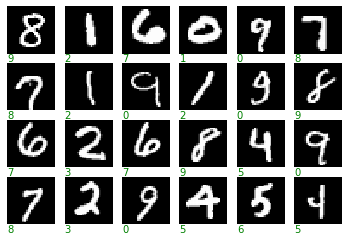

In [57]:
print("MNIST")
plot_some_samples(x_mnist_train, y_mnist_train, ncols=6, nrows=4);

Fashion-MNIST


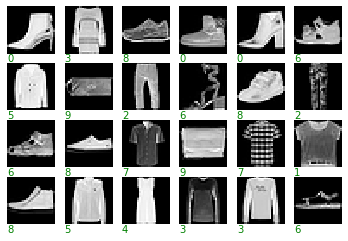

In [58]:
print("Fashion-MNIST")
plot_some_samples(x_mnist_fash_train, y_mnist_fash_train, ncols=6, nrows=4);

#### Exercise 1.3
Prepare for training.

In [59]:
# transform the labels to one hot coding
from keras.utils import to_categorical

y_mnist_train_1hot = to_categorical(y_mnist_train)
y_mnist_test_1hot = to_categorical(y_mnist_test)

for i in range(5):
    print("train : {0} => {1} \ttest : {2} => {3}".format(y_mnist_train[i], y_mnist_train_1hot[i], y_mnist_test[i], y_mnist_test_1hot[i]))

train : 5 => [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.] 	test : 7 => [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
train : 0 => [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 	test : 2 => [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
train : 4 => [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] 	test : 1 => [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
train : 1 => [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.] 	test : 0 => [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
train : 9 => [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.] 	test : 4 => [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


In [60]:
y_mnist_fash_train_1hot = to_categorical(y_mnist_fash_train)
y_mnist_fash_test_1hot = to_categorical(y_mnist_fash_test)

for i in range(5):
    print("train : {0} => {1} \ttest : {2} => {3}".format(y_mnist_fash_train[i], y_mnist_fash_train_1hot[i], y_mnist_fash_test[i], y_mnist_fash_test_1hot[i]))

train : 9 => [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.] 	test : 9 => [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
train : 0 => [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 	test : 2 => [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
train : 0 => [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 	test : 1 => [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
train : 3 => [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.] 	test : 1 => [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
train : 0 => [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 	test : 6 => [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [61]:
# reshape (flatten) the input images to input vectors
print("MNIST")
original_mnist_train_shape = x_mnist_train.shape
original_mnist_test_shape = x_mnist_test.shape
x_mnist_train = x_mnist_train.reshape(x_mnist_train.shape[0], x_mnist_train.shape[1]*x_mnist_train.shape[2])
x_mnist_test = x_mnist_test.reshape(x_mnist_test.shape[0], x_mnist_test.shape[1]*x_mnist_test.shape[2])
print("Reshaped training data from {0} to {1}".format(original_mnist_train_shape, x_mnist_train.shape))
print("Reshaped test data from {0} to {1}".format(original_mnist_test_shape, x_mnist_test.shape))

MNIST
Reshaped training data from (60000, 28, 28) to (60000, 784)
Reshaped test data from (10000, 28, 28) to (10000, 784)


In [62]:
print("Fashion-MNIST")
original_train_shape = x_mnist_fash_train.shape
original_test_shape = x_mnist_fash_test.shape
x_mnist_fash_train = x_mnist_fash_train.reshape(x_mnist_fash_train.shape[0], x_mnist_fash_train.shape[1]*x_mnist_fash_train.shape[2])
x_mnist_fash_test = x_mnist_fash_test.reshape(x_mnist_fash_test.shape[0], x_mnist_fash_test.shape[1]*x_mnist_fash_test.shape[2])
print("Reshaped training data from {0} to {1}".format(original_train_shape, x_mnist_fash_train.shape))
print("Reshaped test data from {0} to {1}".format(original_test_shape, x_mnist_fash_test.shape))

Fashion-MNIST
Reshaped training data from (60000, 28, 28) to (60000, 784)
Reshaped test data from (10000, 28, 28) to (10000, 784)


In [63]:
# MNIST: rescale the input data into the range [0,1]
max_grey_value = 255.0

print("MNIST")
print("Max value in initial dataset (train/test):", np.max(x_mnist_train), np.max(x_mnist_test))
print("Min value in initial dataset (train/test):", np.min(x_mnist_train), np.min(x_mnist_test))
x_mnist_train = x_mnist_train / max_grey_value  
x_mnist_test = x_mnist_test / max_grey_value 
print("Max value in rescaled dataset (train/test):", np.max(x_mnist_train), np.max(x_mnist_test))
print("Min value in rescaled dataset (train/test):", np.min(x_mnist_train), np.min(x_mnist_test))

MNIST
Max value in initial dataset (train/test): 255 255
Min value in initial dataset (train/test): 0 0
Max value in rescaled dataset (train/test): 1.0 1.0
Min value in rescaled dataset (train/test): 0.0 0.0


In [64]:
# MNIST: rescale the input data into the range [0,1]
print("Fashion-MNIST")
print("Max value in initial dataset (train/test):", np.max(x_mnist_fash_train), np.max(x_mnist_fash_test))
print("Min value in initial dataset (train/test):", np.min(x_mnist_fash_train), np.min(x_mnist_fash_test))
x_mnist_fash_train = x_mnist_fash_train / max_grey_value  
x_mnist_fash_test = x_mnist_fash_test / max_grey_value 
print("Max value in rescaled dataset (train/test):", np.max(x_mnist_fash_train), np.max(x_mnist_fash_test))
print("Min value in rescaled dataset (train/test):", np.min(x_mnist_fash_train), np.min(x_mnist_fash_test))

Fashion-MNIST
Max value in initial dataset (train/test): 255 255
Min value in initial dataset (train/test): 0 0
Max value in rescaled dataset (train/test): 1.0 1.0
Min value in rescaled dataset (train/test): 0.0 0.0


In [65]:
# Constants
INPUT_DIM_MNIST = x_mnist_train.shape[1]
INPUT_DIM_MNIST_FASHION = x_mnist_fash_train.shape[1]
MNIST_NUMBER_CLASSES = y_mnist_train_1hot.shape[1]
MNIST_FASHION_NUMBER_CLASSES = y_mnist_fash_train_1hot.shape[1]
print("MMNIST Input Shape {0}; MNIST Number Of Classes {1}".format(INPUT_DIM_MNIST, MNIST_NUMBER_CLASSES))
print("MMNIST Fashion Input Shape {0}; MNIST Fashion Number Of Classes {1}".format(INPUT_DIM_MNIST_FASHION, MNIST_FASHION_NUMBER_CLASSES))

MMNIST Input Shape 784; MNIST Number Of Classes 10
MMNIST Fashion Input Shape 784; MNIST Fashion Number Of Classes 10


## Exercise 2: No hidden layer (10 points)

Define and fit a model without a hidden layer (since we will use multi-layer models later in this project, you can define a general constructor function for models with an arbitrary number of hidden layers already at this point). Note that in this miniproject there is no real test dataset and what is loaded as a test dataset is used for validation. First, implement 1.-3. for the MNIST dataset.  

1. Implement the model with the following specifications: use the softmax activation for the output layer, use the categorical_crossentropy loss, choose stochastic gradient descent for the optimizer, and add the accuracy metric to the metrics. (5 pts)
2. Train for as many epochs as needed to see no further decrease in the validation loss. (1 pt)
3. Plot the learning curves resulting from the fitting procedure (a history object) using the function `plot_history` defined above. (1 pt)
4. Repeat the above steps for fitting the network to the Fashion-MNIST dataset. (2 pts)
5. Report the best validation accuracy achieved for each one of the datasets. Do you observe overfitting already for this simple model? Answer separetely for the MNIST dataset and Fashion-MNIST dataset. (1 pt) 

*Hint:* Read the keras docs, in particular [Getting started with the Keras Sequential model](https://keras.io/getting-started/sequential-model-guide/).

**Answer to Question 5** (max 2 sentences):<br/>
*MNIST:*

We see that the improvement of the validation accuracy levels out around 20 epochs.

If overfitting, we should see the validation loss stopping to decrease (i.e. increasing). Furthermore, since there is a lot of training data for a models with only 7960 parameters it is unlikely that the model is overfitting.

*Fashion-MNIST:*

We see that the improvement of the validation accuracy levels out around after 75 epochs

Same interpretation than MNIST regarding overfitting, even more Fashion-MNIST has been introduced as beeing "harder".

### Solution

#### Exercise 2.1
Implement the model.

In [66]:
# Get number of columns in training data
input_dim_mnist = x_mnist_train.shape[1]

# Get number of classes
mnist_classes_nb = y_mnist_train_1hot.shape[1]

# Use Keras sequential model
model = Sequential()
model.add(Dense(mnist_classes_nb, activation='relu', name="input_layer",  input_shape=(input_dim_mnist,)))
model.add(Dense(mnist_classes_nb, activation='softmax', name="output_layer"))
model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=["accuracy"])
model.name_="model 2.1"
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (Dense)          (None, 10)                7850      
_________________________________________________________________
output_layer (Dense)         (None, 10)                110       
Total params: 7,960
Trainable params: 7,960
Non-trainable params: 0
_________________________________________________________________


#### Exercise 2.2
Train for as many epochs as needed to see no further decrease in the validation loss.

In [67]:
def get_history(x_train, y_train, x_val, y_val, model, epochs, name, early_stop = true):
  """Train model and save history or reload history if file exist."""
  save_dir = 'save'
  numpy_ext = '.npy'
  keras_ext = '.keras'
  path_history = os.path.join(save_dir,  'history_' + name + numpy_ext)
  path_model = os.path.join(save_dir, 'model_' + name + keras_ext)

  if os.path.isdir(save_dir) is not True:
    os.mkdir(save_dir)

  if (os.path.isfile(path_history) & os.path.isfile(path_model)) is not True:
    print("{path_history} and {path_model} doesn't exist.")

    save_callback = ModelCheckpoint(path_model, monitor='val_loss', mode='min', save_best_only=True, verbose=1)
    callbacks = [save_callback]

    if early_stop:
      stop_callback = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
      callbacks.append[stop_callback]    
    
    fit_output = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epochs, callbacks=callbacks, verbose=verbose)
    history = fit_output.history
    np.save(path_history,history)
  else:
    print("loading", path_history)
    history = np.load(path_history,allow_pickle='TRUE').item()

  return history

In [68]:
epochs = 100
history = get_history(x_mnist_train, y_mnist_train_1hot, x_mnist_test, y_mnist_test_1hot, model, epochs, 'ex_2.2')

loading save/history_ex_2.2.npy


#### Exercise 2.3

Plot the learning curves resulting from the fitting procedure (a history object) using the function `plot_history` defined above.

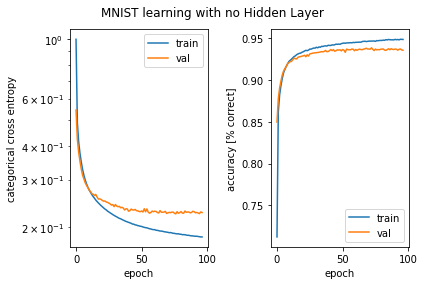

In [69]:
plot_history_cust(history, "MNIST learning with no Hidden Layer");

#### Exercise 2.4

Repeat with the Fashion-MNIST dataset.

In [70]:
# Get number of columns in training data
input_dim_fashion = x_mnist_fash_train.shape[1]

# Get number of classes
fashion_classes_nb = y_mnist_fash_train_1hot.shape[1]

#Define model callbacks
stop_callback = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
callbacks = [stop_callback]

In [71]:
# Use Keras sequential model
model = Sequential()
model.add(Dense(fashion_classes_nb, activation='relu', input_shape=(input_dim_fashion,)))
model.add(Dense(fashion_classes_nb, activation='softmax'))
model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=["accuracy"])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 10)                7850      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                110       
Total params: 7,960
Trainable params: 7,960
Non-trainable params: 0
_________________________________________________________________


In [72]:
history = get_history(x_mnist_fash_train, y_mnist_fash_train_1hot, x_mnist_fash_test, y_mnist_fash_test_1hot, model, epochs, 'ex_2.4')

loading save/history_ex_2.4.npy


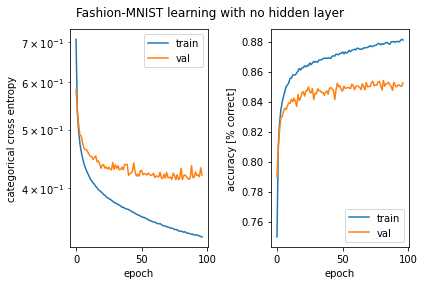

In [73]:
plot_history_cust(history, "Fashion-MNIST learning with no hidden layer ");

We see that the improvement of the validation accuracy levels out around 75 epochs.

## Exercise 3: One hidden layer, different optimizers (10 points)

Train a network with one hidden layer and compare different optimizers for the MNIST dataset.

1. Use one hidden layer with 128 units and the 'relu' activation. Use the [summary method](https://keras.io/api/models/model/#summary-method) to display your model in a compact way. (1 pt)
2. Train the model for at least 50 epochs with different learning rates of stochastic gradient descent (SGD). What happens if the learning rate $\eta$ is very large (for ex. $\eta=1$), and very small (for ex. $\eta=0.001$)? Comment on the fluctuations of the learning curve. (2 pts)
3. Replace the stochastic gradient descent optimizer with the [Adam optimizer](https://keras.io/optimizers/#adam) (you can use the default learning rate). (1pt)
4. Plot the learning curves of SGD with a good learning rate (i.e. in the range [0.01,0.1]) together with the learning curves of Adam in the same figure. Take care of a reasonable labeling of the curves in the plot. (1 pts)
5. Explain the qualitative difference between the loss and accuracy curves with respect to signs of overfitting. Report the best validation accuracy achieved for SGD and Adam. Which one is better and why do you think so? (2 pts)
6. Determine the indices of all test images that are misclassified by the fitted model and plot some of them using the function 
   `plot_some_samples`. (1 pt)

Real-world datasets are labeled by some people and sometimes there are mistakes in the labeling. We will corrupt labels of the MNIST dataset artifically, and observe an overfitting to this noisy dataset with Adam. 

7. Take $ p = 0.2 $ fraction of the data points from the training dataset of MNIST and change their class labels randomly. (You can sample a random integer from 0 to 9 using `np.random.uniform` and `np.floor`). Train with Adam for 50 or 100 epochs. Plot the learning curves. Do you observe overfitting in the validation accuracy? Does it take longer to converge to perfect training accuracy compare to noise-free MNIST? (2 pts)

**Answer to Question 2** (max 2 sentences): We can see in the diagrams that fluctuations of the learning curve are increasing with the learning rate (for small learning rates {0.01, 0.001} almost no fluctuations in the learning curve can be seen anymore and the shape of the learning curve is really smooth). This can be explained by the fact that with a small learning rates, the algorithm makes smaller steps, and so weights change less before correcting direction.

**Answer to Question 5** (max 3 sentences): Adam is faster to learn but at the end they perform in the same way (so faster leaning, but similar performances). We can explain it, saying that the networks are the same, but in Adam case the learning rate is adapting. To get models of similar performances, we must stop learning when it begins to overfit (around 5 epochs for Adam).

**Answer to Question 7** (max 2 sentences): The noisy dataset begins to overfit after around 5 epochs. The model is definetly overfitting to the noise in the noisy MNIST dataset. It takes much longer to converge towards the perfect training accuracy on the noisy MNIST dataset.

### Solution

In [74]:
from keras.layers import Input
from keras.models import Model

def model_1_hidd_layer_128_units(input_dim):
    """Create a model with one hidden layer with 128 units and the 'relu' activation and using given input dimensions."""
    inputs = Input(shape=(input_dim,), name="input_layer")
    layer = Dense(128, activation='relu', name="hidden_layer")(inputs)
    outputs = Dense(mnist_classes_nb, activation='softmax', name="output_layer")(layer)
    model = Model(inputs=inputs, outputs=outputs)

    return model

#### Exercise 3.1

Use one hidden layer with 128 units and the 'relu' activation. Use the [summary method](https://keras.io/api/models/model/#summary-method) to display your model in a compact way.

In [75]:
model = model_1_hidd_layer_128_units(input_dim_mnist)
model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
hidden_layer (Dense)         (None, 128)               100480    
_________________________________________________________________
output_layer (Dense)         (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


#### Exercise 3.2

Train the model for at least 50 epochs with different learning rates of stochastic gradient descent (SGD). What happens if the learning rate  𝜂 is very large (for ex.  𝜂=1), and very small (for ex.  𝜂=0.001)? Comment on the fluctuations of the learning curve.

In [76]:
learning_rates = [10**(-e) for e in range(0,4)]
histories = []
epochs = 50
model = model_1_hidd_layer_128_units(input_dim_mnist)

for lr in learning_rates:
    print("Optimizing model with SGD (lr: {0})".format(lr))
    model = model_1_hidd_layer_128_units(input_dim_mnist)
    model.compile(optimizer=SGD(lr=lr), loss='categorical_crossentropy', metrics=["accuracy"])
    name = 'ex_3.2_lr_{0}'.format(lr)
    history = get_history(x_mnist_train, y_mnist_train_1hot, x_mnist_test, y_mnist_test_1hot, model, epochs, name)
    histories.append(history)

Optimizing model with SGD (lr: 1)
loading save/history_ex_3.2_lr_1.npy
Optimizing model with SGD (lr: 0.1)
loading save/history_ex_3.2_lr_0.1.npy
Optimizing model with SGD (lr: 0.01)
loading save/history_ex_3.2_lr_0.01.npy
Optimizing model with SGD (lr: 0.001)
loading save/history_ex_3.2_lr_0.001.npy


Learning on MNIST dataset


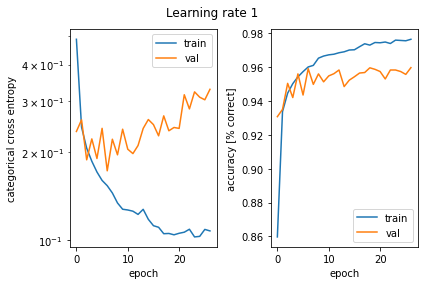

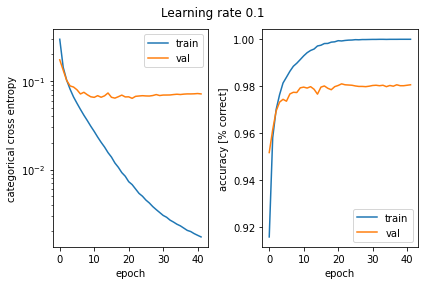

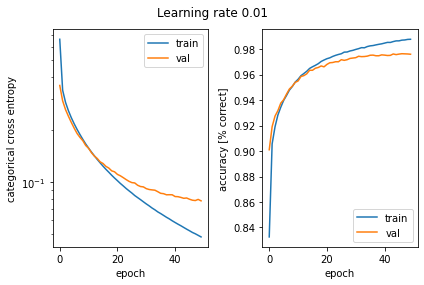

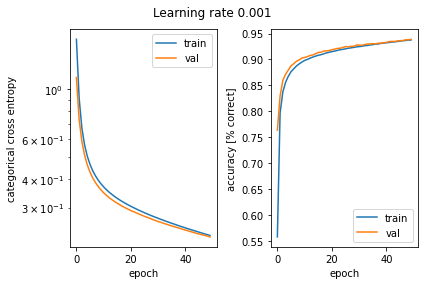

In [77]:
print("Learning on MNIST dataset")
for i in range(len(histories)):
  history = histories[i]
  lr = learning_rates[i]
  plot_history_cust(history, "Learning rate {0}".format(lr));

#### Exercise 3.3

Replace the stochastic gradient descent optimizer with the [Adam optimizer](https://keras.io/optimizers/#adam) (you can use the default learning rate).

In [78]:
model_adam = model_1_hidd_layer_128_units(input_dim_mnist)
adam_lr = 0.001
model_adam.compile(optimizer=Adam(learning_rate=adam_lr), loss='categorical_crossentropy', metrics=["accuracy"])
history_adam = get_history(x_mnist_train, y_mnist_train_1hot, x_mnist_test, y_mnist_test_1hot, model, epochs, 'ex_3.3_lr_{0}'.format(adam_lr))

loading save/history_ex_3.3_lr_0.001.npy


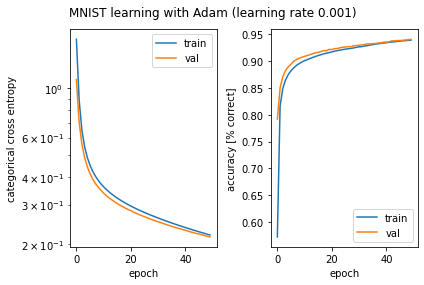

In [79]:
plot_history_cust(history_adam, "MNIST learning with Adam (learning rate {0})".format(adam_lr));

#### Exercise 3.4

Plot the learning curves of SGD with a good learning rate (i.e. in the range [0.01,0.1]) together with the learning curves of Adam in the same figure. Take care of a reasonable labeling of the curves in the plot.


In [80]:
# This plotting routine might help you ...
def comparison_plot(history_sgd, history_adam, label1, label2, title):
    fig, ax1, ax2 = prepare_standardplot(title, "epochs")
    ax1.plot(history_sgd.history['loss'], label=label1 + ' train')
    ax1.plot(history_sgd.history['val_loss'], label=label1 + ' val')
    ax1.plot(history_adam.history['loss'], label=label2 + ' train')
    ax1.plot(history_adam.history['val_loss'], label=label2 + ' val')
    ax2.plot(history_sgd.history['accuracy'], label=label1 + ' train')
    ax2.plot(history_sgd.history['val_accuracy'], label=label1 + ' val')
    ax2.plot(history_adam.history['accuracy'], label=label2 + ' train')
    ax2.plot(history_adam.history['val_accuracy'], label=label2 + ' val')
    finalize_standardplot(fig, ax1, ax2)
    return fig

In [81]:
# Customized plotting function
def comparison_plot_cust(history_sgd, history_adam, label1, label2, title):
    fig, ax1, ax2 = prepare_standardplot(title, "epochs")
    ax1.plot(history_sgd['loss'], label=label1 + ' train')
    ax1.plot(history_sgd['val_loss'], label=label1 + ' val')
    ax1.plot(history_adam['loss'], label=label2 + ' train')
    ax1.plot(history_adam['val_loss'], label=label2 + ' val')
    ax2.plot(history_sgd['accuracy'], label=label1 + ' train')
    ax2.plot(history_sgd['val_accuracy'], label=label1 + ' val')
    ax2.plot(history_adam['accuracy'], label=label2 + ' train')
    ax2.plot(history_adam['val_accuracy'], label=label2 + ' val')
    finalize_standardplot(fig, ax1, ax2)
    return fig

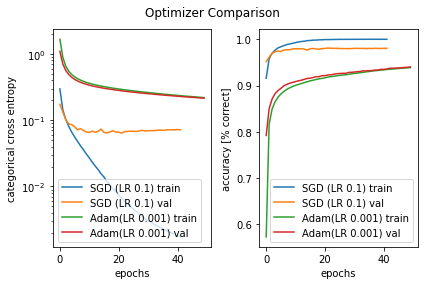

In [82]:
sgd_lr = 0.1
history_sgd = histories[learning_rates.index(sgd_lr)]
comparison_plot_cust(history_sgd, history_adam, "SGD (LR {0})".format(sgd_lr), "Adam(LR {0})".format(adam_lr), "Optimizer Comparison");

#### Exercise 3.5
Explain the qualitative difference between the loss and accuracy curves with respect to signs of overfitting. Report the best validation accuracy achieved for SGD and Adam. Which one is better and why do you think so?

In [83]:
sgd_lr
from keras.models import load_model
model_path = "./save/model_ex_3.2_lr_{0}.keras".format(str(sgd_lr))
model_path


'./save/model_ex_3.2_lr_0.1.keras'

In [84]:
model_sgd = load_model(model_path, compile=True)

In [85]:
err, acc = model_sgd.evaluate(x_mnist_test, y_mnist_test_1hot, verbose=0)
print("{path}: err: {err}, acc: {acc}".format(path=model_path, err=err, acc=acc))

./save/model_ex_3.2_lr_0.1.keras: err: 0.06350480020046234, acc: 0.9803000092506409


In [86]:
model_path = "./save/model_ex_3.3_lr_{0}.keras".format(str(adam_lr))
model_adam = load_model(model_path, compile=True)
err, acc = model_adam.evaluate(x_mnist_test, y_mnist_test_1hot, verbose=0)
print("{name}: err: {err}, acc: {acc}".format(name=model_path, err=err, acc=acc))

./save/model_ex_3.3_lr_0.001.keras: err: 0.21491706371307373, acc: 0.9402999877929688


### Exercise 3.6
Determine the indices of all test images that are misclassified by the fitted model and plot some of them using the function `plot_some_samples`.

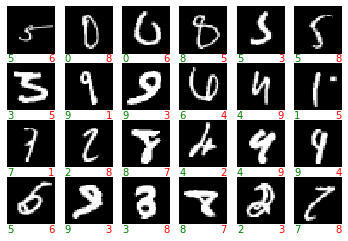

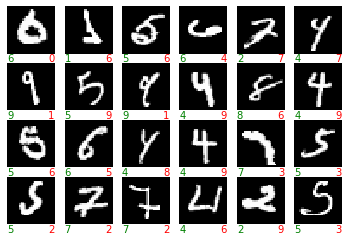

In [87]:
models = [model_sgd, model_adam]
for model in models:
    y_pred = model.predict_on_batch(x_mnist_test).argmax(axis=1)
    indices = [i for i,v in enumerate(y_pred) if y_pred[i]!=y_mnist_test[i]]
    x_wrongly_predicted = np.asarray([x_mnist_test[i] for i in indices])
    y_wrongly_predicted = np.asarray([y_pred[i] for i in indices])
    y_true_prediction = np.asarray([y_mnist_test[i] for i in indices])
    plot_some_samples_cust(x_wrongly_predicted, y_true_prediction, y_wrongly_predicted, ncols=6, nrows=4);

#### Exercise 3.7

7. Take $ p = 0.2 $ fraction of the data points from the training dataset of MNIST and change their class labels randomly. (You can sample a random integer from 0 to 9 using `np.random.uniform` and `np.floor`). Train with Adam for 50 or 100 epochs. Plot the learning curves. Do you observe overfitting in the validation accuracy? Does it take longer to converge to perfect training accuracy compare to noise-free MNIST? (2 pts)<br/>
**=> The training accuracy is increasing, starting from 80% and reaching around 90% after 100 episodes. The validation accuracy on the other hand is decreasing from 95% to around 80% after 100 episodes. The model is definetly overfitting to the noise in the shifted MNIST dataset. It takes much longer to converge towards the perfect training accuracy on the noisy MNIST dataset.**

In [89]:
# Define indices to noise
p = 0.2 # define fraction of the data points
mnist_train_length = original_mnist_train_shape[0]
indices = np.arange(mnist_train_length)
noise_number_mnist = int(mnist_train_length*p)
noisy_indices = np.random.choice(indices, noise_number_mnist)

# Generate noisy labels
y_mnist_train_1hot_noisy = y_mnist_train_1hot.copy()
for index in noisy_indices:
  class_index = np.floor(np.random.uniform(0,9.99))
  vector = to_categorical(class_index, num_classes=mnist_classes_nb)
  y_mnist_train_1hot_noisy[index] = vector

# Train with noisy labels
history_adam_noisy = model.compile(optimizer=Adam(learning_rate=adam_lr), loss='categorical_crossentropy', metrics=["accuracy"])
epochs=100
history_adam_noisy = get_history(x_mnist_train,y_mnist_train_1hot_noisy, x_mnist_test, y_mnist_test_1hot, 
                                 model, epochs=epochs, name = 'ex_3.7_lr_{0}'.format(adam_lr), early_stop = False)

{path_history} and {path_model} doesn't exist.
Epoch 1/100
1875/1875 [==============================] - 6s 3ms/step - loss: 0.9949 - accuracy: 0.8110 - val_loss: 0.3077 - val_accuracy: 0.9590

Epoch 00001: val_loss improved from inf to 0.30774, saving model to save/model_ex_3.7_lr_0.001.keras
Epoch 2/100
1875/1875 [==============================] - 6s 3ms/step - loss: 0.8968 - accuracy: 0.8213 - val_loss: 0.3091 - val_accuracy: 0.9660

Epoch 00002: val_loss did not improve from 0.30774
Epoch 3/100
1875/1875 [==============================] - 6s 3ms/step - loss: 0.8691 - accuracy: 0.8221 - val_loss: 0.3117 - val_accuracy: 0.9644

Epoch 00003: val_loss did not improve from 0.30774
Epoch 4/100
1875/1875 [==============================] - 6s 3ms/step - loss: 0.8475 - accuracy: 0.8231 - val_loss: 0.2844 - val_accuracy: 0.9649

Epoch 00004: val_loss improved from 0.30774 to 0.28438, saving model to save/model_ex_3.7_lr_0.001.keras
Epoch 5/100
1875/1875 [==============================] - 6s 3

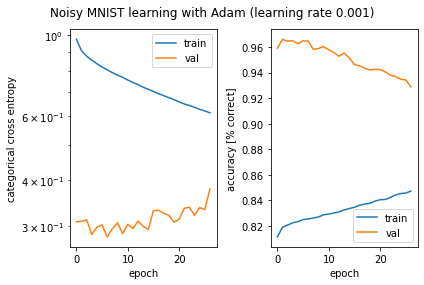

In [90]:
plot_history_cust(history_adam_noisy, "Noisy MNIST learning with Adam (learning rate {0})".format(adam_lr));

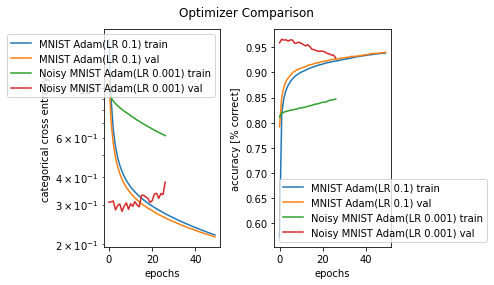

In [91]:
comparison_plot_cust(history_adam, history_adam_noisy, "MNIST Adam(LR {0})".format(sgd_lr), "Noisy MNIST Adam(LR {0})".format(adam_lr), "Optimizer Comparison");

In [92]:
def unison_shuffle(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

# Calculate the number of samples that need to be replaced.
length = int(np.floor(0.2 * len(y_mnist_train)))

y_random = np.empty(0)
for i in range(length):
    y_random = np.append(y_random, np.floor(np.random.uniform(0,9.9)))

# new dataset
x_mnist_train_shuffled = x_mnist_train.copy()
y_mnist_train_noisy = y_mnist_train.copy()

# Shuffle the dataset (that step is not necessary, but allow to make a random noise, in the follosing step)
x_mnist_train_shuffled, y_mnist_train_noisy = unison_shuffle(x_mnist_train_shuffled, y_mnist_train_noisy)

# Replace the labels of the first n training samples with random lables.
y_mnist_train_noisy[:length] = y_random

# Shuffle the X and y data in order to spread the random labels equally over the dataset
x_mnist_train_shuffled, y_mnist_train_noisy = unison_shuffle(x_mnist_train_shuffled, y_mnist_train_noisy)

# One hot encoding
y_mnist_train_noisy_1hot = to_categorical(y_mnist_train_noisy)

In [93]:
model = model_1_hidd_layer_128_units(input_dim=input_dim_mnist)
mc = ModelCheckpoint('./models/exercise-3.7/model.keras', monitor='val_loss', mode='min', save_best_only=True, verbose=1)
model.compile(optimizer=Adam(learning_rate=adam_lr), loss='categorical_crossentropy', metrics=["accuracy"])
fit_output_adam_noisy = model.fit(x_mnist_train_shuffled, y_mnist_train_noisy_1hot, validation_data=(x_mnist_test, y_mnist_test_1hot), epochs=epochs, verbose=1, callbacks=[mc])

Epoch 1/100
1875/1875 [==============================] - 6s 3ms/step - loss: 1.2142 - accuracy: 0.7136 - val_loss: 0.3872 - val_accuracy: 0.9490

Epoch 00001: val_loss improved from inf to 0.38724, saving model to ./models/exercise-3.7/model.keras
Epoch 2/100
1875/1875 [==============================] - 5s 3ms/step - loss: 1.0158 - accuracy: 0.7828 - val_loss: 0.3536 - val_accuracy: 0.9593

Epoch 00002: val_loss improved from 0.38724 to 0.35362, saving model to ./models/exercise-3.7/model.keras
Epoch 3/100
1875/1875 [==============================] - 5s 3ms/step - loss: 0.9635 - accuracy: 0.7956 - val_loss: 0.3393 - val_accuracy: 0.9641

Epoch 00003: val_loss improved from 0.35362 to 0.33933, saving model to ./models/exercise-3.7/model.keras
Epoch 4/100
1875/1875 [==============================] - 5s 3ms/step - loss: 0.9452 - accuracy: 0.7973 - val_loss: 0.3416 - val_accuracy: 0.9617

Epoch 00004: val_loss did not improve from 0.33933
Epoch 5/100
1875/1875 [============================

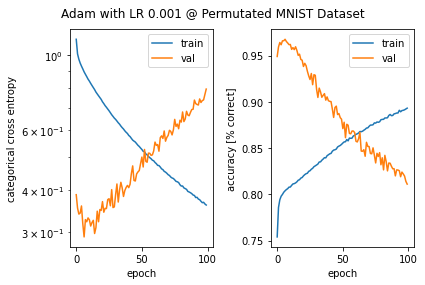

In [95]:
plot_history(history_adam, "Adam with LR {0} @ Permutated MNIST Dataset".format(adam_lr));

In [ ]:
comparison_plot_cust(history_adam, fit_output_adam_noisy.history, "MNIST Adam(LR {0})".format(sgd_lr), "Noisy MNIST Adam(LR {0})".format(adam_lr), "Optimizer Comparison");

## Exercise 4: Model performance as a function of number of hidden neurons (8 + 2 points)

Since the MNIST dataset is almost perfectly solved already by a one-hidden-layer network in Exercise 3, we use the Fashion-MNIST dataset from now on to compare the performances of more complex models. In this exercise, we investigate how the best validation loss and accuracy depends on the number of hidden neurons in a single layer.

1. Fit at least 4 models with different number of hidden neurons (i.e. width) between 10 and 1000 to the Fashion-MNIST dataset. Train with Adam for 50-100 epochs. (2 pts)
2. Plot the best validation loss and accuracy versus the width. Is the observed trend in accordance with the [general approximation theorem](https://en.wikipedia.org/wiki/Universal_approximation_theorem)? Do you observe an overfitting due to the complexity of the wider networks with more parameters? Report the best validation accuracy. (2 pts)
3. Choose $ p \geq 0.5 $ fraction of the data points from the training dataset of Fashion-MNIST and change their class labels randomly as in Exercise 3. For this noisy Fashion-MNIST dataset, fit at least 4 models with different widths between 10 and 250. Train with Adam for at least 150 epochs. Plot the best validation loss and accuracy vs. width. (2 pts)
4. BONUS: Add random Gaussian noise on the input pixels with mean 0 and variance between 0.01-0.5 and use the original labels. For this noisy Fashion-MNIST dataset, fit at least 4 models with different widths between 10 and 250. Train with Adam for at least 150 epochs. Plot the best validation loss and accuracy vs. width. (2 pts)
5. Answer to the same questions in 2 for the noisy Fashion-MNIST dataset(s). Comment on the differences between width-performence curves for these two (or three) datasets. (2 pts)

In this exercise we fit each model only for one initialization and random seed. In practice one would collect some statistics (e.g. 25-, 50-, 75-percentiles) for each layer size by fitting each model several times with different initializations and the random seeds. You may also want to do this here. It is a good exercise, but not mandatory as it takes quite a bit of computation time.

**Answer to Question 2** (max 2 sentences):
The Universal Approximation Theorem states that a neural network with one hidden layer and unlimited number of hidden neurons can approximate any continuous function for inputs within a specific range and this can also be observed with our example, since the best training accuracy is steadily increasing with the number of hidden neurons.
We can see that our different models are overfitting and the overfitting increases with an increasing number of hidden neurons.

**Answer to Question 5** (max 3 sentences): 
Although the training and validation accuracy of exercise 4.3's models is quite low (since the 50% of the training labels got changed), we can still see that the training accuracy rises significantly with the number of hidden neurons (From 12% to 26%). A neural network with many hidden nodes is still able to learn this highly dataset correctly and achieve a high training accuracy (in accordance with the universal approximation theorem).
In exercise 4.4 we can see that fitting to this slightly noisy dataset still works pretty well, although the model is also overfitting.

#### Exercise 4 - Helper Functions

In [ ]:
def return_model_with_n_hidden_neurons(n_hidden_neurons):
    # Get number of columns in training data
    inputs = Input(shape=(INPUT_DIM,), name="input_layer")
    layer = Dense(n_hidden_neurons, activation='relu', name="hidden_layer")(inputs)
    outputs = Dense(10, activation='softmax', name="output_layer")(layer)

    model = Model(inputs=inputs, outputs=outputs, name="ex3.1")
    return model

In [ ]:
import glob
def plot_histories(base_path):
    #print(base_path)
    model_history_paths = glob.glob(base_path + '/*.npy')
    for model_history_path in model_history_paths:
        history=np.load(model_history_path, allow_pickle='TRUE').item()
        plot_dict_history(history, model_history_path);

In [ ]:
def load_metrics(base_path, numbers_of_hidden_neurons):
    metrics = {"x": [], "min_loss": [], "min_val_loss": [], "max_accuracy": [], "max_val_accuracy": []}
    for number_of_hidden_neurons in numbers_of_hidden_neurons:
        model_history_path = '{0}/ANN-with-{1}-hidden-neurons.npy'.format(base_path, number_of_hidden_neurons)
        history=np.load(model_history_path, allow_pickle='TRUE').item()
        metrics["x"].append(number_of_hidden_neurons)
        metrics["min_loss"].append(min(history["loss"]))
        metrics["min_val_loss"].append(min(history["val_loss"])) 
        metrics["max_accuracy"].append(max(history["accuracy"]))
        metrics["max_val_accuracy"].append(max(history["val_accuracy"]))
        #print(metrics)
    return metrics

In [ ]:
def plot_metrics(metrics):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle('Validation loss and accuracy / Number of hidden neurons')
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=None)
    fig.set_figheight(6)
    fig.set_figwidth(12)
    ax1.set_xscale('log',base=10)
    ax1.set_ylabel("Validation loss")
    ax1.set_xlabel("number of hidden neurons")
    ax1.plot(metrics["x"], metrics["min_loss"])
    ax1.plot(metrics["x"], metrics["min_val_loss"])
    ax2.set_xscale('log',base=10)
    ax2.set_ylabel("Validation accuracy")
    ax2.set_xlabel("number of hidden neurons")
    ax2.plot(metrics["x"], metrics["max_accuracy"]);
    ax2.plot(metrics["x"], metrics["max_val_accuracy"]);
    finalize_standardplot(fig, ax1, ax2)

#### Exercise 4.1 & 4.2
Fit at least 4 models with different number of hidden neurons (i.e. width) between 10 and 1000 to the Fashion-MNIST dataset. Train with Adam for 50-100 epochs. (2 pts)

In [ ]:
base_path = "./models/exercise-4.1"
numbers_of_hidden_neurons = [10, 50, 100, 500, 1000]
already_trained = []
number_of_epochs = 50
verbose=2

In [ ]:
for number_of_hidden_neurons in numbers_of_hidden_neurons:
    # Since the training process sometimes break we need to manually restart it
    # with the next network that has not been trained yet.
    if number_of_hidden_neurons in already_trained:
        continue;
        
    print("Training network with {} hidden neurons".format(number_of_hidden_neurons))
    model_path = '{0}/ANN-with-{1}-hidden-neurons.keras'.format(base_path, number_of_hidden_neurons)
    model_history_path = '{0}/ANN-with-{1}-hidden-neurons.npy'.format(base_path, number_of_hidden_neurons)
    
    model = return_model_with_n_hidden_neurons(number_of_hidden_neurons)
    mc = ModelCheckpoint('{0}/ANN-with-{1}-hidden-neurons.keras'.format(base_path, number_of_hidden_neurons), monitor='val_loss', mode='min', save_best_only=True, verbose=verbose)
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=["accuracy"])
    history = model.fit(x_mnist_fash_train, y_mnist_fash_train_1hot, validation_data=(x_mnist_fash_test, y_mnist_fash_test_1hot), epochs=number_of_epochs, validation_split=0.2, verbose=verbose, callbacks=[mc])
    np.save(model_history_path, history.history)

In [ ]:
plot_histories(base_path)

In [ ]:
plot_metrics(load_metrics(base_path, numbers_of_hidden_neurons))

In [ ]:
metrics = load_metrics(base_path, numbers_of_hidden_neurons)
print(metrics["max_val_accuracy"])

#### Exercise 4.3
Choose $ p \geq 0.5 $ fraction of the data points from the training dataset of Fashion-MNIST and change their class labels randomly as in Exercise 3. For this noisy Fashion-MNIST dataset, fit at least 4 models with different widths between 10 and 250. Train with Adam for at least 150 epochs. Plot the best validation loss and accuracy vs. width. (2 pts)

In [ ]:
def unison_shuffle(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

# Calculate the number of samples that need to be replaced.
length = int(np.floor(0.5 * len(y_mnist_fash_train)))

y_random = np.empty(0)
for i in range(length):
    y_random = np.append(y_random, np.floor(np.random.uniform(0,9.9)))

# Replace the labels of the first n training samples with random lables.
y_mnist_fash_train_noisy = y_mnist_fash_train.copy()
y_mnist_fash_train_noisy[:length] = y_random

# Shuffle the X and y data in order to spread the random labels equally over the dataset
x_mnist_fash_train_shuffled, y_mnist_fash_train_noisy_shuffled = unison_shuffle(x_mnist_fash_train, y_mnist_fash_train_noisy)

# One hot encoding
y_mnist_fash_train_noisy_shuffled_1hot = to_categorical(y_mnist_fash_train_noisy_shuffled)

In [ ]:
numbers_of_hidden_neurons = [10, 50, 100, 150, 200, 250] 
already_trained = []
number_of_epochs = 150
base_path = './models/exercise-4.3' 
verbose=True

In [ ]:
for number_of_hidden_neurons in numbers_of_hidden_neurons:
    # Since the training process sometimes break we need to manually restart it
    # with the next network that has not been trained yet.
    if number_of_hidden_neurons in already_trained:
        continue;
        
    print("--- Training network with {} hidden neurons ---".format(number_of_hidden_neurons))
    
    model = return_model_with_n_hidden_neurons(number_of_hidden_neurons)
    model_path = '{0}/ANN-with-{1}-hidden-neurons.keras'.format(base_path, number_of_hidden_neurons)
    model_history_path = '{0}/ANN-with-{1}-hidden-neurons.npy'.format(base_path, number_of_hidden_neurons)
    
    mc = ModelCheckpoint(model_path, monitor='val_loss', mode='min', save_best_only=True, verbose=verbose)
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=["accuracy"])
    history = model.fit(x_mnist_fash_train, y_mnist_fash_train_noisy_shuffled_1hot, validation_data=(x_mnist_fash_test, y_mnist_fash_test_1hot), epochs=number_of_epochs, validation_split=0.2, verbose=verbose, callbacks=[mc])
    
    np.save(model_history_path, history.history)

In [ ]:
plot_histories(base_path)

In [ ]:
plot_metrics(load_metrics(base_path, numbers_of_hidden_neurons))

### Exercise 4.4
Add random Gaussian noise on the input pixels with mean 0 and variance between 0.01-0.5 and use the original labels. For this noisy Fashion-MNIST dataset, fit at least 4 models with different widths between 10 and 250. Train with Adam for at least 150 epochs. Plot the best validation loss and accuracy vs. width. (2 pts)

In [ ]:
# Prepare data for exercise 4.4
import math

number_of_training_images = x_mnist_fash_train.shape[0]
number_of_input_features = x_mnist_fash_train.shape[1]

noise = np.random.normal(0,math.sqrt(0.1),(number_of_training_images, number_of_input_features))
x_mnist_fash_train_noisy = x_mnist_fash_train + noise

In [ ]:
# Define hyperparameters for exercise 4.4
numbers_of_hidden_neurons = [10, 50, 100, 150, 200, 250] 
already_trained = []
number_of_epochs = 150
base_path = './models/exercise-4.4' 
verbose=False

In [ ]:
for number_of_hidden_neurons in numbers_of_hidden_neurons:
    # Since the training process sometimes break we need to manually restart it
    # with the next network that has not been trained yet.
    if number_of_hidden_neurons in already_trained:
        continue;
        
    print("--- Training network with {} hidden neurons ---".format(number_of_hidden_neurons))
    
    model = return_model_with_n_hidden_neurons(number_of_hidden_neurons)
    model_path = '{0}/ANN-with-{1}-hidden-neurons.keras'.format(base_path, number_of_hidden_neurons)
    model_history_path = '{0}/ANN-with-{1}-hidden-neurons.npy'.format(base_path, number_of_hidden_neurons)
    
    mc = ModelCheckpoint(model_path, monitor='val_loss', mode='min', save_best_only=True, verbose=verbose)
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=["accuracy"])
    history = model.fit(x_mnist_fash_train_noisy, y_mnist_fash_train_1hot, validation_data=(x_mnist_fash_test, y_mnist_fash_test_1hot), epochs=number_of_epochs, validation_split=0.2, verbose=2, callbacks=[mc])
    
    np.save(model_history_path, history.history)

In [ ]:
plot_histories(base_path)

In [ ]:
plot_metrics(load_metrics(base_path, numbers_of_hidden_neurons))

## Exercise 5: Going deeper: tricks and regularization (10 + 2 points)

Adding hidden layers to a deep network does not necessarily lead to a straight-forward improvement of performance. We use Fashion-MNIST dataset in this exercise.  

1. Choose a width $ h $ between 50-200 and use at least two hidden layers with $ h $ hidden neurons (each) and train the network for at least 150 epochs. (2 pts)
2. Plot the learning curves and report the best validation accuracy. Do you observe overfitting? (2 pts)
3. Keep the network at the same size. Use a very large l2 regularization $\lambda$ (for ex. $\lambda=1$) and a small one (for ex. $\lambda=0.001$) on kernel weights and report the validation accuracies. What do you observe?  (2 pts)
4. Turn off the $ \ell_2 $ regularization and use a large dropout rate (for ex. 0.5) and a small one (for ex. 0.05) at all hidden layers and report the validation accuracies. What do you observe? (2 pts)
5. BONUS: Try built-in data augmentation methods as a way to regularize: this may include horizontal flipping of the images or small rotations. You can use built-in methods in Keras. Report the augmentation method you used and the best validation accuracy. (2 pts)

Note that one needs to cross-validate to find the right regularization parameter for the model you chose and for the dataset at hand. However we do not enforce this hyperparameter search as it takes long computation times but it is a good practice if you try it here. 

6. Compare the validation accuracies resulting from your attempts to reduce overfitting. Did you improve the validation accuracy? If not, comment on the possible sources of failure. (2 pts)

**Answer to Question 2** (max 1 sentence):<br/>
Overfitting can be observed in the training process since the loss is decreasing but the validation loss is increasing and the validation accuracy levels out after 25 epochs although the training accuracy still keeps increasing.

Best validation accuracy: 0.8906999826431274

**Answer to Question 3** (max 2 sentences): 

**Answer to Question 4** (max 2 sentences): 

**Answer to Question 5 (BONUS)** (max 2 sentences): 

**Answer to Question 6** (max 2 sentences): 

### Solution

#### Helper Functions

In [ ]:
def return_new_model (dropout_rate = 0, l2_regularization_parameter = 0):
  model = Sequential()
  model.add(Dense(128, activation='relu', input_shape=(INPUT_DIM_MNIST_FASHION,), kernel_regularizer=regularizers.l1_l2(l1=0, l2=l2_regularization_parameter)))
  if(dropout_rate > 0):
      model.add(Dropout(dropout_rate))
  model.add(Dense(128, activation='relu', input_shape=(INPUT_DIM_MNIST_FASHION,), kernel_regularizer=regularizers.l1_l2(l1=0, l2=l2_regularization_parameter)))
  if(dropout_rate > 0):
    model.add(Dropout(dropout_rate))
  model.add(Dense(MNIST_FASHION_NUMBER_CLASSES, activation='softmax'))
  return model

#### Exercise 5.1
Choose a width $ h $ between 50-200 and use at least two hidden layers with $ h $ hidden neurons (each) and train the network for at least 150 epochs.
#### Exercise 5.2
Plot the learning curves and report the best validation accuracy. Do you observe overfitting?


In [ ]:
model = return_new_model()
model.summary()

In [ ]:
def train_model(model, x_train, y_train, x_test, y_test, model_path, number_of_epochs):
  mc = ModelCheckpoint("{0}.keras".format(model_path), monitor='val_loss', mode='min', save_best_only=True, verbose=verbose)
  model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=["accuracy"])
  history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=number_of_epochs, verbose=verbose, callbacks=[mc])
  np.save("{0}.npy".format(model_path), history.history)

In [ ]:
model_5_1 = return_new_model()
base_path = './models/exercise-5.1/model'
history_path = "{0}.npy".format(base_path)

In [ ]:
train_model(model_5_1, x_mnist_fash_train, y_mnist_fash_train_1hot, x_mnist_fash_test, y_mnist_fash_test_1hot, base_path, number_of_epochs=150)

In [ ]:
history = np.load(history_path, allow_pickle=True).item()
plot_history_cust(history, history_path);
print("Best validation accuracy: {0}".format(max(history["val_accuracy"])))

#### Exercise 5.3
Keep the network at the same size. Use a very large l2 regularization $\lambda$ (for ex. $\lambda=1$) and a small one (for ex. $\lambda=0.001$) on kernel weights and report the validation accuracies. What do you observe?

In [ ]:
model_5_3_1 = return_new_model (dropout_rate = 0, l2_regularization_parameter = 1)
model_5_3_1.summary()
base_path = './models/exercise-5.3/model_1'
history_path = "{0}.npy".format(base_path)

In [ ]:
train_model(model_5_3_1, x_mnist_fash_train, y_mnist_fash_train_1hot, x_mnist_fash_test, y_mnist_fash_test_1hot, base_path, number_of_epochs=150)

In [ ]:
history = np.load(history_path, allow_pickle=True).item()
plot_history_cust(history, history_path);
print("Best validation accuracy: {0}".format(max(history["val_accuracy"])))

In [ ]:
model_5_3_2 = return_new_model (dropout_rate = 0, l2_regularization_parameter = 0.001)
model_5_3_2.summary()
base_path = './models/exercise-5.3/model_2'
history_path = "{0}.npy".format(base_path)

In [ ]:
train_model(model_5_3_2, x_mnist_fash_train, y_mnist_fash_train_1hot, x_mnist_fash_test, y_mnist_fash_test_1hot, base_path, number_of_epochs=150)

In [ ]:
history = np.load(history_path, allow_pickle=True).item()
plot_history_cust(history, history_path);
print("Best validation accuracy: {0}".format(max(history["val_accuracy"])))

#### Exercise 5.4
Turn off the $ \ell_2 $ regularization and use a large dropout rate (for ex. 0.5) and a small one (for ex. 0.05) at all hidden layers and report the validation accuracies. What do you observe?

In [ ]:
model_5_4_1 = return_new_model(dropout_rate = 0.5, l2_regularization_parameter = 0)
base_path = './models/exercise-5.4/model_1'
history_path = "{0}.npy".format(base_path)
model = return_new_model(dropout_rate = 0.5, l2_regularization_parameter = 0)
model.summary()

In [ ]:
train_model(model_5_4_1, x_mnist_fash_train, y_mnist_fash_train_1hot, x_mnist_fash_test, y_mnist_fash_test_1hot, base_path, number_of_epochs=150)

In [ ]:
history = np.load(history_path, allow_pickle=True).item()
plot_history_cust(history, history_path);
print("Best validation accuracy: {0}".format(max(history["val_accuracy"])))

In [ ]:
model_5_4_2 = return_new_model(dropout_rate = 0.05, l2_regularization_parameter = 0)
base_path = './models/exercise-5.4/model_2'
history_path = "{0}.npy".format(base_path)
model.summary()

In [ ]:
train_model(model_5_4_2, x_mnist_fash_train, y_mnist_fash_train_1hot, x_mnist_fash_test, y_mnist_fash_test_1hot, base_path, number_of_epochs=150)

In [ ]:
history = np.load(history_path, allow_pickle=True).item()
plot_history_cust(history, history_path);
print("Best validation accuracy: {0}".format(max(history["val_accuracy"])))

#### Exercise 5.5

BONUS: Try built-in data augmentation methods as a way to regularize: this may include horizontal flipping of the images or small rotations. You can use built-in methods in Keras. Report the augmentation method you used and the best validation accuracy. (2 pts)

Note that one needs to cross-validate to find the right regularization parameter for the model you chose and for the dataset at hand. However we do not enforce this hyperparameter search as it takes long computation times but it is a good practice if you try it here. 

#### Exercise5.6. 

Compare the validation accuracies resulting from your attempts to reduce overfitting. Did you improve the validation accuracy? If not, comment on the possible sources of failure.

## Exercise 6: Convolutional neural networks (CNNs) (10 points)

Convolutional neural networks have an inductive bias that is well adapted to image classification. 

1. Design a convolutional neural network and train it without using explicit regularizers. (2 pts)
2. Try to improve the best validation scores of the model by experiment with batch_normalization layers, dropout layers and l2-regularization on weights (kernels) and biases. (4 pts)
3. After you have found good settings, plot the learning curves for both models, naive (=no tricks/regularization) and tuned (=tricks + regularized) together in a comparison plot. (2pts)
4. How does the CNN performance compare to the so far best performing (deep) neural network model? (2 pts)

*Hint:* You may get valuable inspiration from the keras [examples](https://keras.io/examples/), [for example](https://keras.io/examples/vision/mnist_convnet/).

**Answer to Question 4**: 

### Solution